<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>Часть 4. Где логистическая регрессия хороша и где не очень

### Анализ отзывов IMDB к фильмам

Будем решать задачу бинарной классификации отзывов IMDB к фильмам. Имеется обучающая выборка с размеченными отзывами, по 12500 отзывов известно, что они хорошие, еще про 12500 – что они плохие. Здесь уже не так просто сразу приступить к машинному обучению, потому что готовой матрицы $X$ нет  – ее надо приготовить. Будем использовать самый простой подход – мешок слов ("Bag of words"). При таком подходе признаками отзыва будут индикаторы наличия в нем каждого слова из всего корпуса, где корпус – это множество всех отзывов. Идея иллюстрируется картинкой

<img src="../../img/bag_of_words.svg" width=80%>

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**Загрузим данные [отсюда](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) (это прямая ссылка на скачивание, а [вот](http://ai.stanford.edu/~amaas/data/sentiment/) описание набора данных). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.**

In [31]:
# поменяйте путь к файлу
reviews_train = load_files("../../data/imdb_data/train/")
text_train, y_train = reviews_train.data, reviews_train.target

In [32]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [61]:
# поменяйте путь к файлу
reviews_test = load_files("../../data/imdb_data/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Пример отзыва и соответствующей метки.**

In [39]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [38]:
y_train[1] # плохой отзыв

0

In [41]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [40]:
y_train[2] # хороший отзыв

1

## Простой подсчет слов

**Составим словарь всех слов с помощью CountVectorizer.**

In [42]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.**

In [43]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.**

In [44]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Посмотрим, как преобразование подействовало на одно из предложений.**

In [45]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [46]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [48]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

**Преобразуем так же тестовую выборку.**

In [62]:
X_test = cv.transform(text_test)

**Обучим логистическую регрессию.**

In [50]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 25.1 s, sys: 872 ms, total: 26 s
Wall time: 13.8 s


**Посмотрим на доли правильных ответов на обучающей и тестовой выборках.**

In [63]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.998, 0.867)

**Коэффициенты модели можно красиво отобразить.**

In [64]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [65]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
    

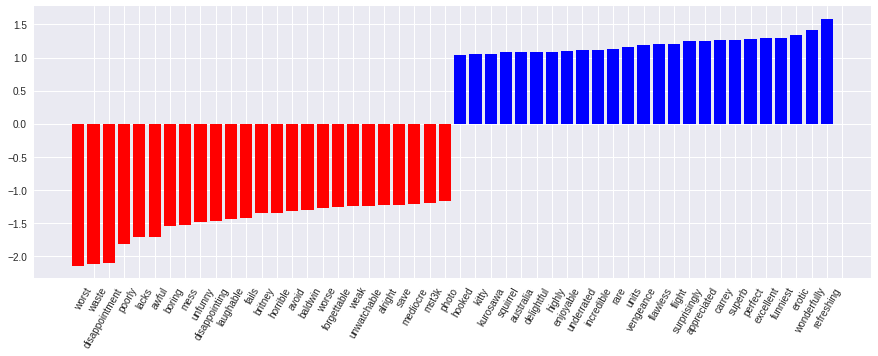

In [66]:
visualize_coefficients(logit, cv.get_feature_names())

**Подберем коэффициент регуляризации для логистической регрессии. Используем `sklearn.pipeline`, поскольку `CountVectorizer` правильно применять только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов). В данном случае `pipeline` задает последовательность действий: применить `CountVectorizer`, затем обучить логистическую регрессию.**

In [67]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.86672
CPU times: user 32.7 s, sys: 944 ms, total: 33.6 s
Wall time: 20.8 s


In [68]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

CPU times: user 15.8 s, sys: 1.11 s, total: 16.9 s
Wall time: 2min 12s


**Лучшее значение C и соответствующее качество на кросс-валидации:**

In [70]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.88524)

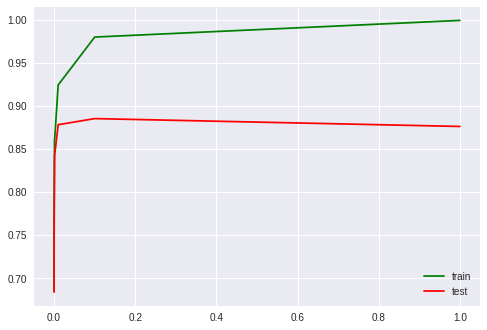

In [71]:
plot_grid_scores(grid_logit, 'logisticregression__C')

На валидационной выборке:

In [72]:
grid_logit.score(text_test, y_test)

0.87908

**Теперь то же самое, но со случайным лесом. Видим, что с логистической регрессией мы достигаем большей доли правильных ответов меньшими усилиями**

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [75]:
%%time
forest.fit(X_train, y_train)

CPU times: user 3min 51s, sys: 368 ms, total: 3min 52s
Wall time: 1min 2s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [76]:
round(forest.score(X_test, y_test), 3)

0.855

### XOR-проблема
Теперь рассмотрим пример, где линейные модели справляются хуже. 

Линейные методы классификации строят все же очень простую разделяющую поверхность – гиперплоскость. Самый известный игрушечный пример, в котором классы нельзя без ошибок поделить гиперплоскостью (то есть прямой, если это 2D), получил имя "the XOR problem".

XOR – это "исключающее ИЛИ", булева функция со следующей таблицей истинности:

<img src='../../img/XOR_table.gif'>

XOR дал имя простой задаче бинарной классификации, в которой классы представлены вытянутыми по диагоналям и пересекающимися облаками точек. 

In [77]:
# порождаем данные
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

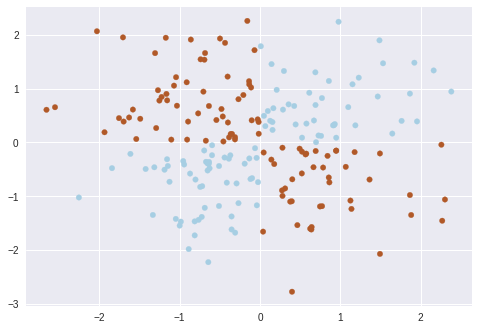

In [78]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Очевидно, нельзя провести прямую так, чтобы без ошибок отделить один класс от другого. Поэтому логистическая регрессия плохо справляется с такой задачей. 

In [79]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

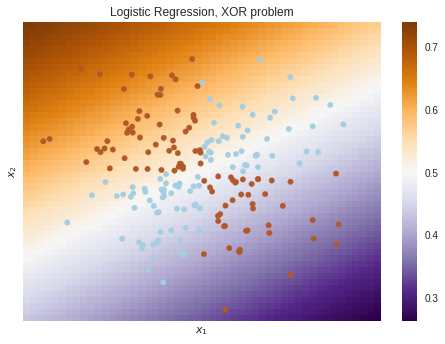

In [80]:
plot_boundary(LogisticRegression(), X, y,
              "Logistic Regression, XOR problem")

А вот если на вход подать полиномиальные признаки, в данном случае до 2 степени, то проблема решается. 

In [81]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [82]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])

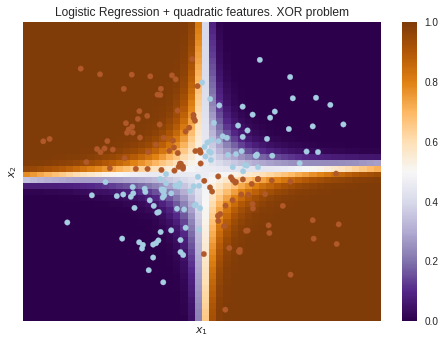

In [83]:
plot_boundary(logit_pipe, X, y,
              "Logistic Regression + quadratic features. XOR problem")

Здесь логистическая регрессия все равно строила гиперплоскость, но в 6-мерном пространстве признаков $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$. В проекции на исходное пространство признаков $x_1, x_2$ граница получилась нелинейной. 

На практике полиномиальные признаки действительно помогают, но строить их явно – вычислительно неэффективно. Гораздо быстрее работает SVM с ядровым трюком. При таком подходе в пространстве высокой размерности считается только расстояние между объектами (задаваемое функцией-ядром), а явно плодить комбинаторно большое число признаков не приходится. Про это подробно можно почитать в курсе Евгения Соколова – [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem10_linear.pdf) (математика уже серьезная).